<a href="https://colab.research.google.com/github/Monoxido45/Active_learning_tests/blob/master/modules/active_learning_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Exemplos simples de Active learning:** 



*   Primeiramente iremos usar o banco de dados iris, para uma pequena pratica:



In [2]:
# pacotes importados
import numpy as np
import pandas as pd

# para os graficos
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns

# PCA e os dados de interesse
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

Antes de realizar o active learning para o exemplo do iris, podemos explorar o banco de dados:

In [3]:
# importando o IRIS
iris = load_iris()

# transformando o objeto iris em um data frame pandas
iris_data = pd.DataFrame(data = np.c_[iris['data'], iris['target']],
                         columns = iris['feature_names'] + ['target'])


# vendo apenas as 10 primeiras observacoes
iris_data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


Primeiramente, podemos fazer uma matriz de gráfico de dispersão

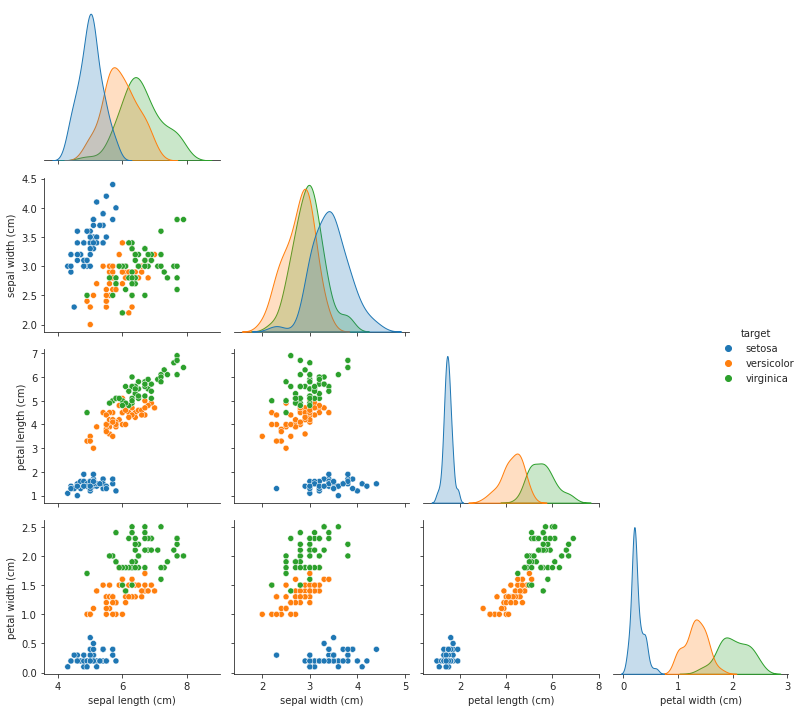

In [4]:
# dados para a analise descritiva
iris_desc = iris_data.copy()

replace_data = {"target" : {0.0: iris['target_names'][0],
                            1.0: iris['target_names'][1],
                            2.0: iris['target_names'][2]}}

iris_desc = iris_desc.replace(replace_data)
sns.set_style("ticks")

sns.pairplot(iris_desc, hue = "target", corner=True)
plt.tight_layout()

Além disso, também podemos fazer uma matriz de correlação:

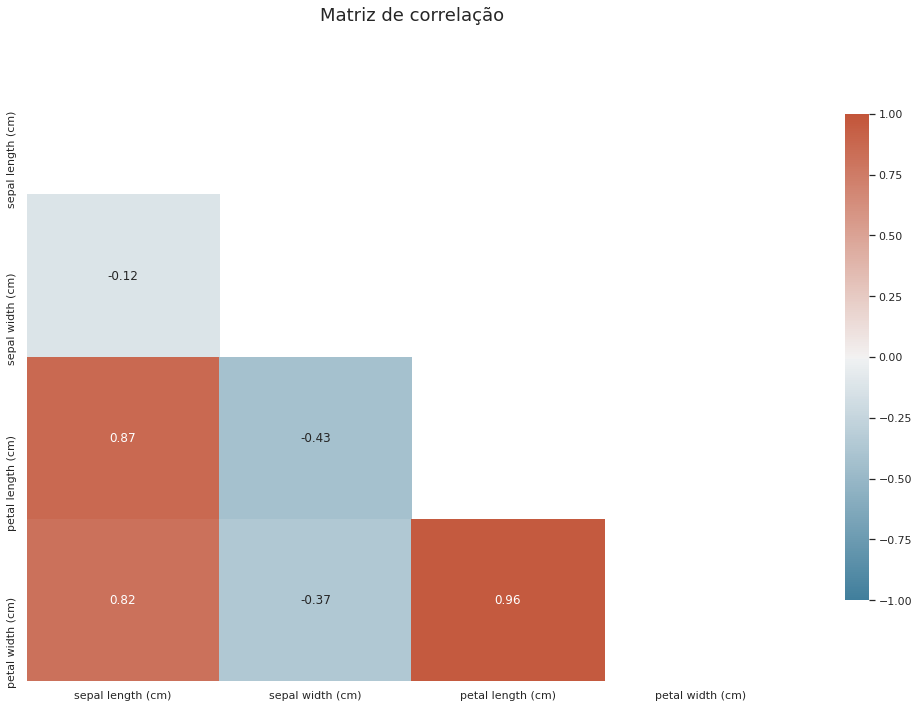

In [5]:
sns.set_theme(style="white")

# fazendo a matriz de correlacao usando mascaras
corr = iris_desc.corr()
mask = np.triu(np.ones_like(corr))

# figura do matplotlib
f, ax = plt.subplots(figsize=(14, 10))

# palheta customizada
cmap = sns.diverging_palette(230, 20, as_cmap = True)

heatmap = sns.heatmap(corr, mask=mask, vmax= 1, vmin = -1, cmap = cmap, cbar_kws={"shrink": .75}, annot = True)
heatmap.set_title('Matriz de correlação', fontdict={'fontsize':18}, pad=12)
plt.tight_layout()

E por fim alguns violinplots separados:

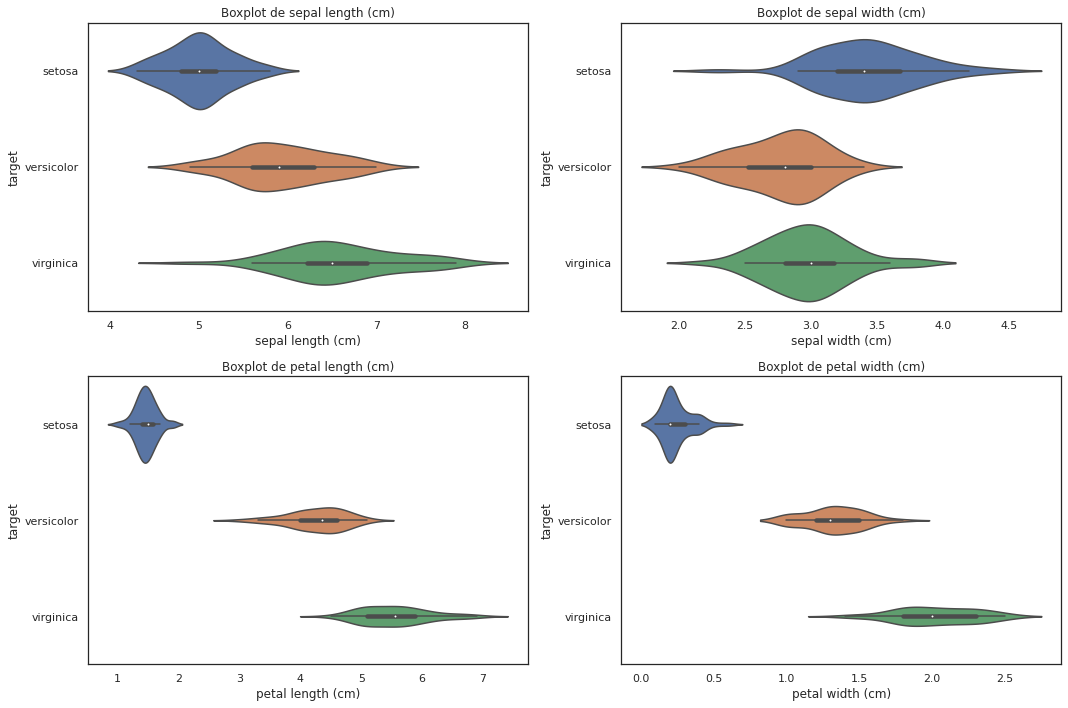

In [6]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10))
medidas = iris_desc.columns
for i in range(0,4):
  j = i + 1
  plt.subplot(2,2,j)
  sns.violinplot(x = medidas[i], y = "target", data = iris_desc, orient = "h")
  plt.title("Boxplot de {}".format(medidas[i]))

plt.tight_layout()

Por fim, podemos checar se os níveis da variável target são balanceados a partir de um gráfico de barras:

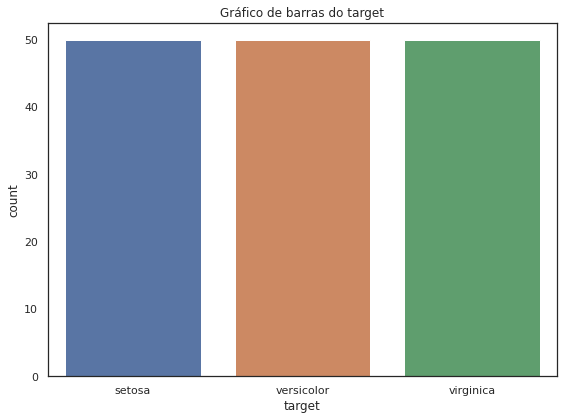

In [7]:
fig, axes = plt.subplots(figsize = (8, 6))
sns.countplot(x = 'target', data = iris_desc)
plt.title("Gráfico de barras do target")
plt.tight_layout()

Parece haver uma igualdade de frequência das diferentes espécies. Assim, vemos pela matriz de correlação alta correlação entre comprimento de sépala e ambas medidas de pétala (comprimento e largura). Além disso, o comprimento de pétala tem alta correlação com a largura. Podemos reduzir a dimensão da matriz de covariaveis ao utilizar uma analise de componentes principais. Isso será interessante para analisar de forma bivariada a performance dos modelos a seguir:

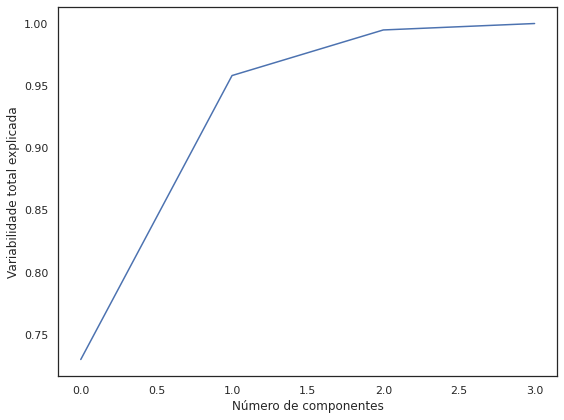

In [8]:
# separando features e target
X = iris_data.iloc[:, 0:4].values
y = iris_data.iloc[:, 4].values

# escalonando os dados
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

# obtendo o PCA com todos os componentes
pca = PCA()
pca_fit = pca.fit(X)
# avaliando a variancia explicada
fig, axes = plt.subplots(figsize = (8, 6))
plt.plot(np.cumsum(pca_fit.explained_variance_ratio_))
plt.xlabel("Número de componentes")
plt.ylabel("Variabilidade total explicada")
plt.tight_layout()

Observa-se que dois componentes de fato são suficientes para a analise, tendo portanto:

In [9]:
pca = PCA(n_components=2)

pcs = pca.fit_transform(X)

pcs[1:10, :]
X = pcs

Obtendo um gráfico de dispersão 2D com os dois componentes principais:

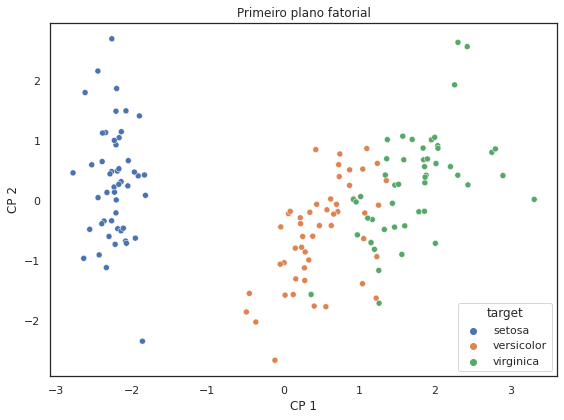

In [10]:
principalDf = pd.DataFrame(data = pcs,
             columns = ['CP 1', 'CP 2'])

principalDf = pd.concat([principalDf, iris_desc[['target']]], axis = 1)

fig, axes = plt.subplots(figsize = (8, 6))
sns.scatterplot(data = principalDf, x = "CP 1", y = "CP 2", hue = "target")
plt.title("Primeiro plano fatorial")
plt.tight_layout()

Podemos então agora, utilizando o pacote modAL para realizar um active learning, utilizando inicialmente a amostragem por incerteza, e posteriormente o queriyng by comitee:

In [11]:
# importando estimadores tanto para amostrar pela incerteza quanto montar o comite
!pip install modAL
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from modAL import ActiveLearner, Committee
from modAL.uncertainty import uncertainty_sampling

# declarando o learner para o random forest
learner_rf = ActiveLearner(
    estimator = RandomForestClassifier(),
    query_strategy = uncertainty_sampling
)

# declarando o learner para o KNN
learner_knn = ActiveLearner(
    estimator = KNeighborsClassifier(n_neighbors = 5),
    query_strategy = uncertainty_sampling
)

# fixando a semente
seed = 1450
np.random.seed(seed)

# setando as amostras iniciais:
# 20 para treinamento inicial
n_initial = 20
X_pool = np.copy(X)
y_pool = np.copy(y)
train_idx = np.random.choice(range(X_pool.shape[0]), size = n_initial, replace = False)
X_train = X_pool[train_idx]
y_train = y_pool[train_idx]

# reduzindo a pool
X_pool = np.delete(X_pool, train_idx, axis=0)
y_pool = np.delete(y_pool, train_idx)

# tomando uma pool para RF e outra para KNN
X_pool_rf = np.copy(X_pool)
y_pool_rf = np.copy(y_pool)

X_pool_knn = np.copy(X_pool)
y_pool_knn = np.copy(y_pool)

learner_rf.teach(X_train, y_train)
learner_knn.teach(X_train, y_train)

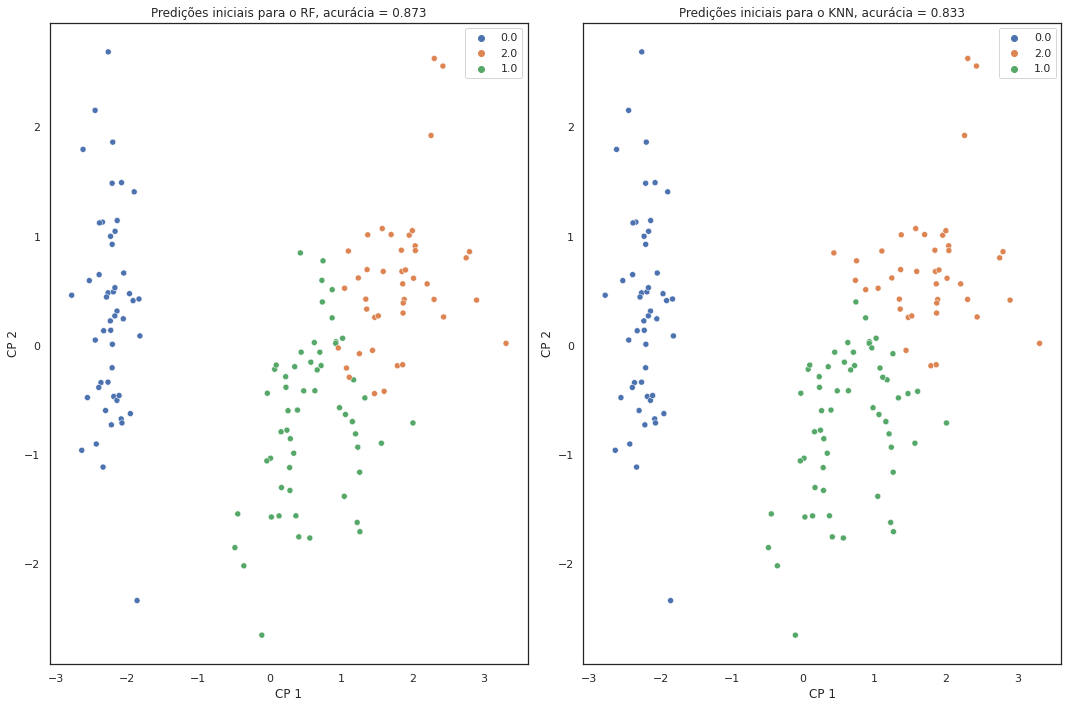

In [12]:
unqueried_score_rf = learner_rf.score(X, y)
unqueried_score_knn = learner_knn.score(X, y)

unqueried_scores = [unqueried_score_rf, unqueried_score_knn]
learners = [learner_rf, learner_knn]
names = ["RF", "KNN"]
plt.figure(figsize = (15, 10))

for i in range(0,2):
  plt.subplot(1, 2, i + 1)
  prediction = learners[i].predict(X)
  sns.scatterplot(data = principalDf, x = "CP 1", y = "CP 2", hue = prediction.astype('str'))
  plt.title("Predições iniciais para o %s, acurácia = %1.3f" % (names[i], unqueried_scores[i]))

plt.tight_layout()

In [13]:
n_queries = 20
performance_history_rf = [unqueried_score_rf]
performance_history_knn = [unqueried_score_knn]


for index in range(n_queries):
  # obtendo o indice para perguntar os labels
  query_index_rf, query_instance_rf = learner_rf.query(X_pool_rf)
  query_index_knn, query_instance_knn = learner_knn.query(X_pool_knn)

  # ensinando o activelearner
  # Random Forest
  X_sel, y_sel = X_pool_rf[query_index_rf].reshape(1, -1), y_pool_rf[query_index_rf].reshape(1, )
  learner_rf.teach(X = X_sel, y = y_sel)
  X_pool_rf, y_pool_rf = np.delete(X_pool_rf, query_index_rf, axis=0), np.delete(y_pool_rf, query_index_rf)
  
  # KNN
  X_sel, y_sel = X_pool_knn[query_index_knn].reshape(1, -1), y_pool_knn[query_index_knn].reshape(1, )
  learner_knn.teach(X = X_sel, y = y_sel)
  X_pool_knn, y_pool_knn = np.delete(X_pool_knn, query_index_knn, axis=0), np.delete(y_pool_knn, query_index_knn)

  # acuracia para cada modelo com a nova observacao
  model_accuracy_rf = learner_rf.score(X, y)
  model_accuracy_knn = learner_knn.score(X, y)
  
  # historico de performance para ambos
  performance_history_rf.append(model_accuracy_rf)
  performance_history_knn.append(model_accuracy_knn)

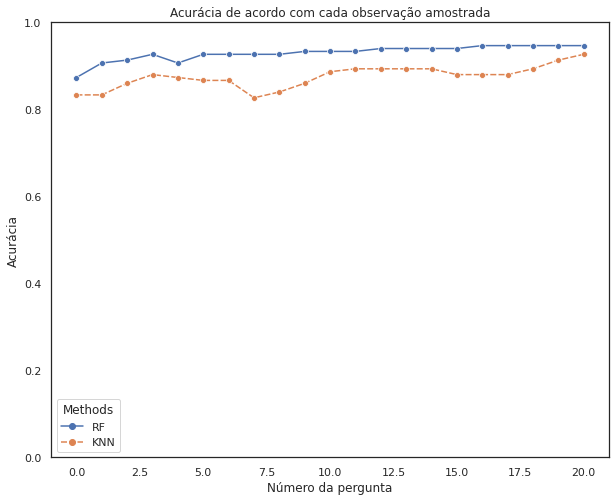

In [14]:
names = ["RF", "KNN"]
plt.figure(figsize = (10, 8))

data = pd.DataFrame(data = {'Acuracia': performance_history_rf + performance_history_knn, 
                            'Query': np.tile(np.arange(0,21), 2),
                            'Methods':np.concatenate((np.full(shape = 21, fill_value = "RF"), 
                                                         np.full(shape = 21, fill_value = "KNN")))})

sns.lineplot(data = data, x = "Query", y = "Acuracia", markers=["o", "o"], hue = "Methods", style="Methods") 
plt.title("Acurácia de acordo com cada observação amostrada")
plt.xlabel("Número da pergunta")
plt.ylabel("Acurácia")
plt.ylim(0, 1)
plt.show()

In [15]:
# iniciando o comite
n_members = 2
learner_list = list()

# tomando a pool inicial
n_initial = 20
X_pool = np.copy(X)
y_pool = np.copy(y)
train_idx = np.random.choice(range(X_pool.shape[0]), size = n_initial, replace = False)
X_train = X_pool[train_idx]
y_train = y_pool[train_idx]
X_pool = np.delete(X_pool, train_idx, axis=0)
y_pool = np.delete(y_pool, train_idx)

# lista de classificadores sendo usado
classifier_list = ["RandomForestClassifier()", "KNeighborsClassifier()"]

for member_idx in range(n_members):

    # iniciando os learner
    learner = ActiveLearner(
        estimator= eval(classifier_list[member_idx]),
        X_training = X_train, y_training = y_train
    )
    learner_list.append(learner)

# assembling the committee
committee = Committee(learner_list=learner_list)

Fazendo o active learner e o histórico de performance do query by comittee:

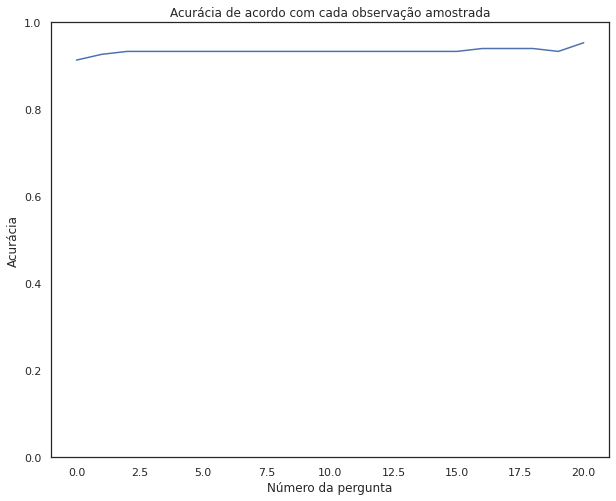

In [16]:
unqueried_score = committee.score(X, y)
performance_history = [unqueried_score]

# query by committee
n_queries = 20
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool)
    committee.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    performance_history.append(committee.score(X, y))
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)

plt.figure(figsize = (10, 8))

data = pd.DataFrame(data = {'Acuracia': performance_history, 
                            'Query': np.arange(0,21)})

sns.lineplot(data = data, x = "Query", y = "Acuracia", markers=True) 
plt.title("Acurácia de acordo com cada observação amostrada")
plt.xlabel("Número da pergunta")
plt.ylabel("Acurácia")
plt.ylim(0, 1)
plt.show()

Agora que treinamos a sintaxe no banco de dados IRIS, façamos um teste em um banco de dados com label binario e com bastante observação. Usaremos o banco de dados de marketing de banco:

In [17]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [18]:
# lendo os dados
bank_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/active_learning/bank.csv', sep = ";")
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [19]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [20]:
bank_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


Primeiramente, podemos analisar os boxplots de cada feature e separar de acordo com o label:

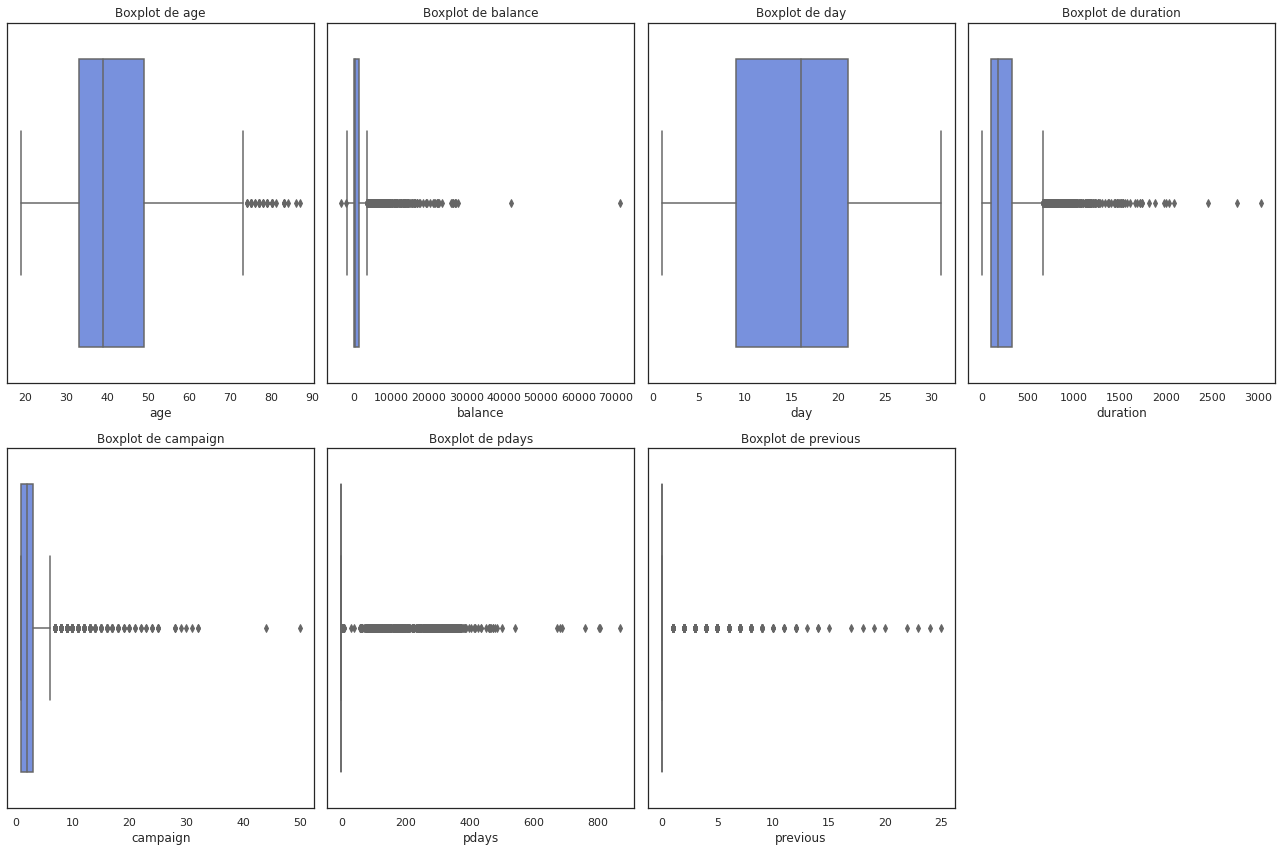

In [21]:
sns.set_palette("coolwarm")
sns.color_palette("Set1")
columns_int = bank_df.select_dtypes(include='number').columns

fig, axes = plt.subplots(2, 4, figsize = (18, 12))

i = 0
for col in columns_int:
  i += 1
  plt.subplot(2, 4, i)
  sns.boxplot(data = bank_df, x = col)
  plt.title("Boxplot de {}".format(col))
  plt.xlabel(col)

fig.delaxes(axes[1][3])
plt.tight_layout()

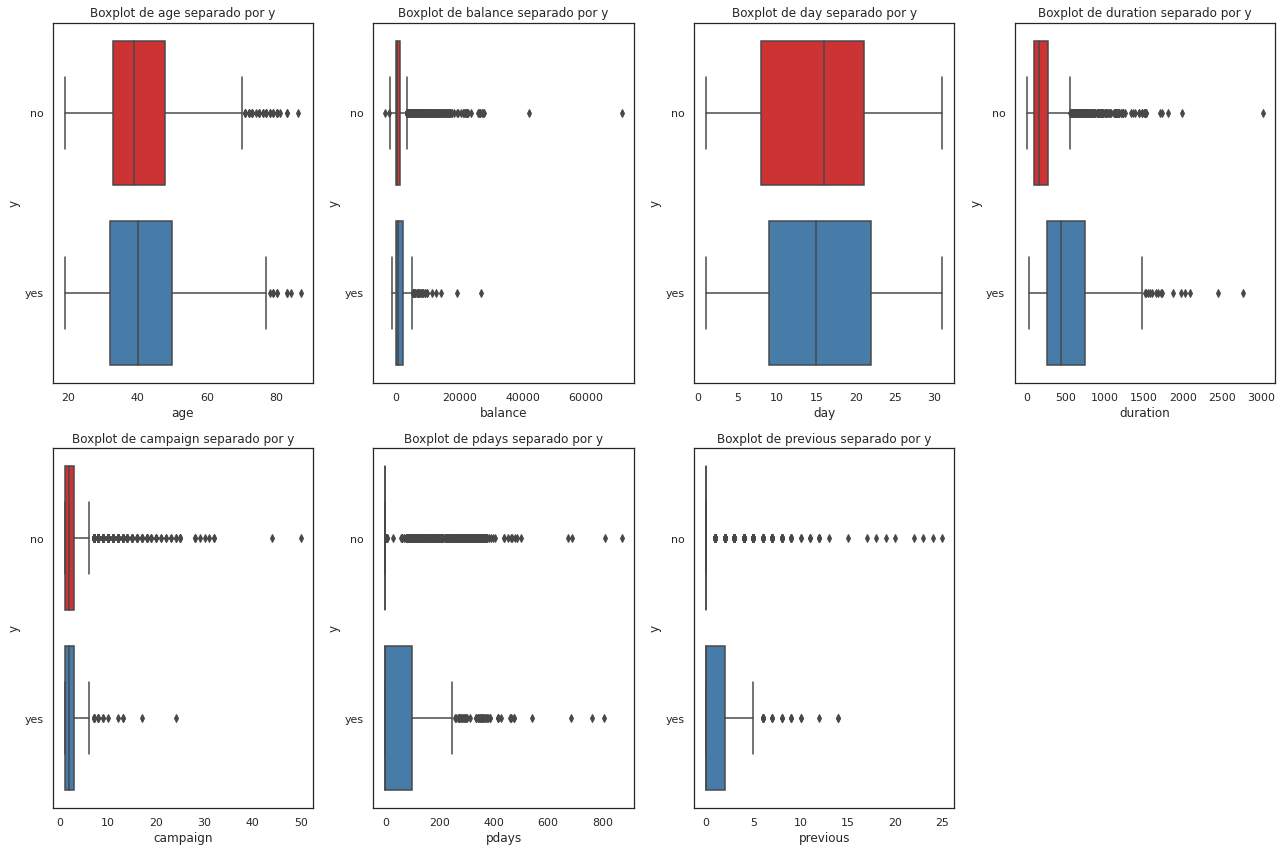

In [23]:
sns.set_palette("Set1") 
columns_int = bank_df.select_dtypes(include='number').columns

fig, axes = plt.subplots(2, 4, figsize = (18, 12))

i = 0
for col in columns_int:
  i += 1
  plt.subplot(2, 4, i)
  sns.boxplot(data = bank_df, x = col, y = "y", orient = "h")
  plt.title("Boxplot de {} separado por y".format(col))
  plt.xlabel(col)

fig.delaxes(axes[1][3])
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


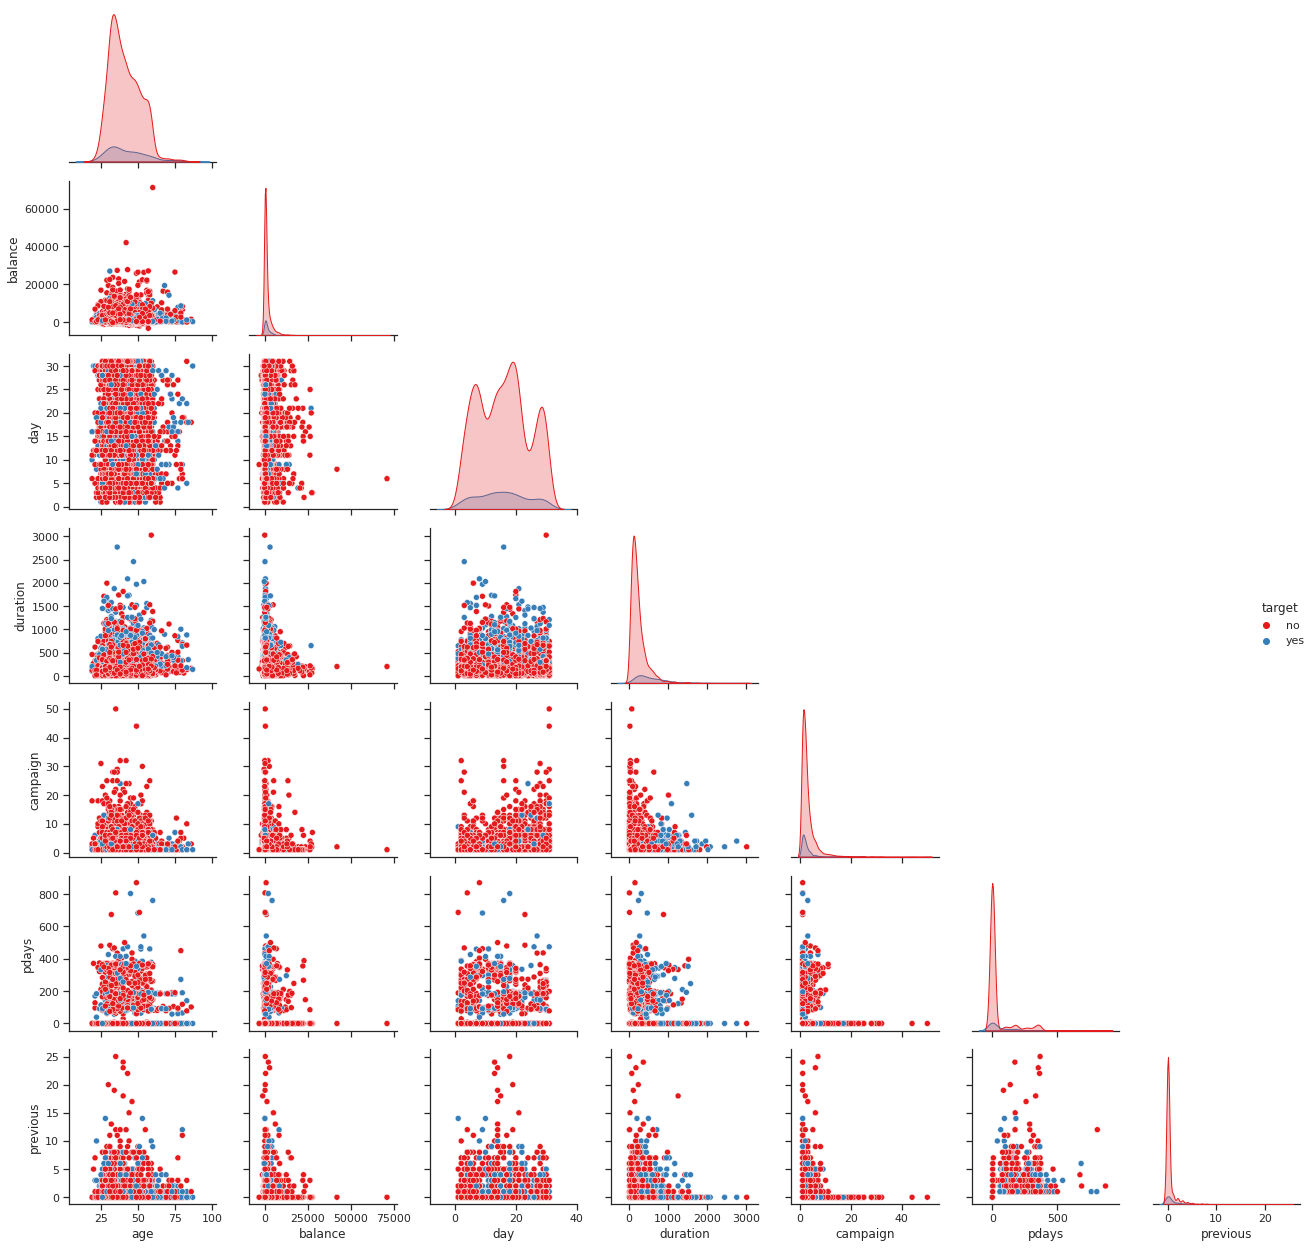

In [24]:
bank_desc = bank_df.select_dtypes(include='number')
sns.set_style("ticks")
bank_desc["target"] = bank_df.loc[:, "y"]

sns.pairplot(bank_desc, hue = "target", corner=True)
plt.tight_layout()

Analisando agora as variáveis categóricas:

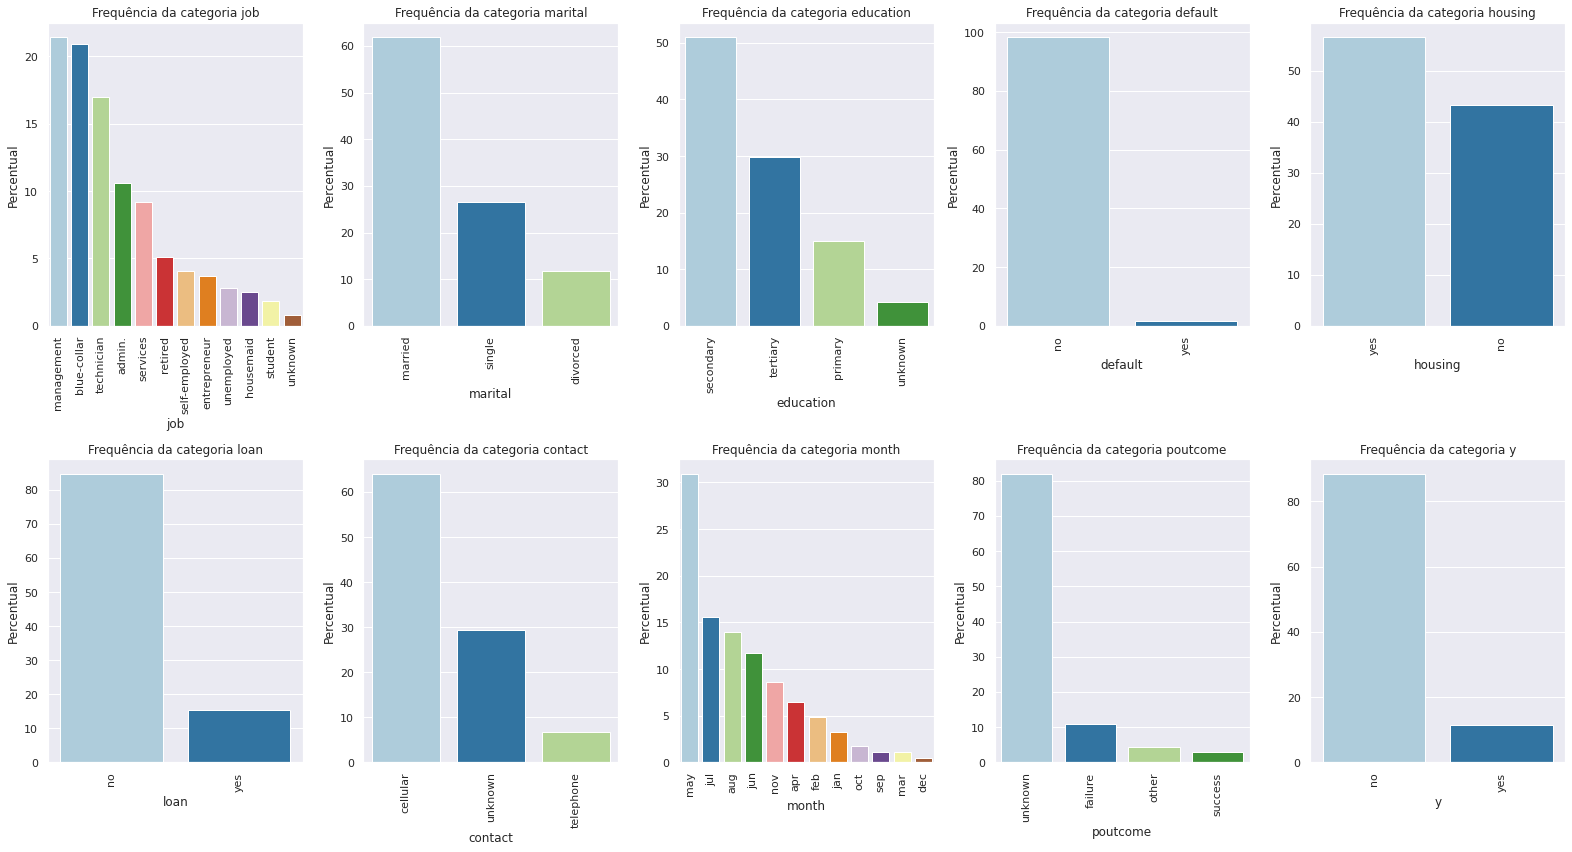

In [25]:
# visualizando a partir de varios gráficos de barras
sns.set_theme(style="darkgrid")
sns.set_palette("Paired")
columns_cat = bank_df.select_dtypes(include='object').columns

fig, axes = plt.subplots(2, 5, figsize = (22, 12))

i = 0
for col in columns_cat:
  i += 1
  plt.subplot(2, 5, i)
  temp_data = (bank_df.loc[:, col].value_counts(normalize = True)
  .mul(100)
  .rename('percent')
  .reset_index())
  sns.barplot(x="index", y="percent", data = temp_data)
  plt.title("Frequência da categoria {}".format(col))
  plt.xlabel(col)
  plt.ylabel("Percentual")
  plt.xticks(rotation=90)

plt.tight_layout()

Separando os dados pelo target, para analisar quao bem cada feature separa bem o target:

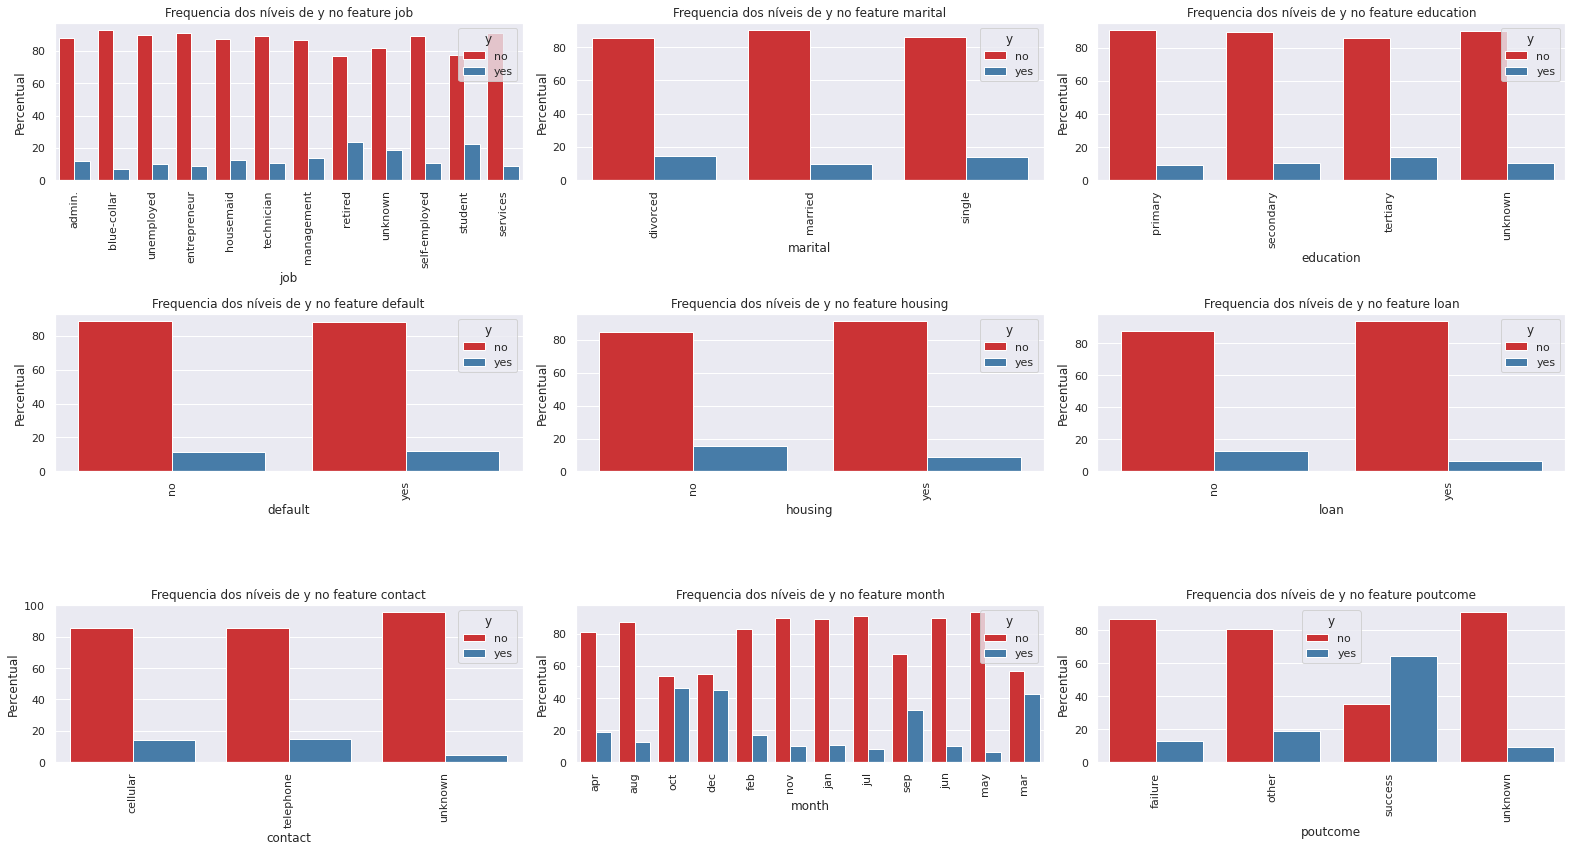

In [26]:
sns.set_palette("Set1")
columns_cat = (bank_df.select_dtypes(include='object')
.drop(["y"], axis = 1).columns)

fig, axes = plt.subplots(3, 3, figsize = (22, 12))

i = 0
for col in columns_cat:
  i += 1
  plt.subplot(3, 3, i)
  temp_data = (bank_df.groupby([col])['y']
               .value_counts(normalize = True)
  .mul(100)
  .rename('percent')
  .reset_index()
  .sort_values('y'))
  sns.barplot(x = col, y="percent", hue = "y", data = temp_data)
  plt.title("Frequencia dos níveis de y no feature {}".format(col))
  plt.xlabel(col)
  plt.ylabel("Percentual")
  plt.xticks(rotation=90)

plt.tight_layout()

Separando agora as covariaveis e os labels para posteriormente dividir em treino e teste:

In [63]:
# transformando categoricas em dummy
cols_ind = (bank_df.select_dtypes(include='object').drop(['y'], axis = 1)
.columns)

# criando as dummies
df_final = pd.get_dummies(bank_df, columns = cols_ind, drop_first=True)

# Separando X e y
X = df_final.drop(['y'], axis = 1).values
y = bank_df.loc[:, 'y'].values

# separando em pool e teste
from sklearn.model_selection import train_test_split
X_pool,X_test,y_pool,y_test = train_test_split(X, y, test_size = 0.3, random_state = 120, stratify = y)

Agora que separamos a pool e o teste, podemos por fim, selecionar 30 observações para compor nosso conjunto inicial

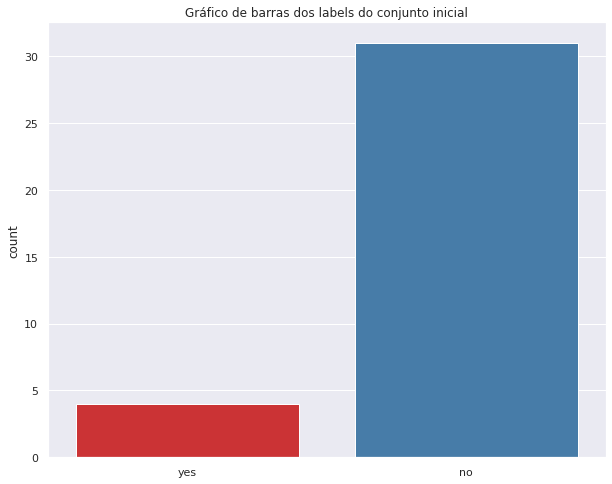

In [64]:
seed = 120
np.random.seed(seed)
n_initial = 35

train_idx = np.random.choice(range(len(X_pool)), size = n_initial, replace = False)
X_train = X_pool[train_idx]
y_train = y_pool[train_idx]

X_pool = np.delete(X_pool, train_idx, axis=0)
y_pool = np.delete(y_pool, train_idx)

plt.figure(figsize = (10,8))
sns.countplot(x = y_train)
plt.title("Gráfico de barras dos labels do conjunto inicial")
plt.show()